In [ ]:
!pip install obspy

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# df_train = pd.read_csv("/kaggle/input/liverpool-ion-switching/train.csv")
# df_test = pd.read_csv("/kaggle/input/liverpool-ion-switching/test.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

BATCH_SIZE = 500000
WINDOW_SIZE = 50

for i in range(10):
    df_train.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

for i in range(4):
    df_test.loc[i * BATCH_SIZE:((i + 1) * BATCH_SIZE) - 1, 'batch'] = i

df_train['batch'] = df_train['batch'].astype(np.uint8)
df_test['batch'] = df_test['batch'].astype(np.uint8)

df_train['mean'] = df_train.groupby('batch')['signal'].rolling(WINDOW_SIZE, min_periods=1).mean().reset_index()['signal']
df_train['detrended'] = df_train['signal'] - df_train['mean']

df_train.head()

,time,signal,open_channels,batch,mean,detrended
0,0.0001,-2.7600,0,0,-2.760000,0.000000
1,0.0002,-2.8557,0,0,-2.807850,-0.047850
2,0.0003,-2.4074,0,0,-2.674367,0.266967
3,0.0004,-3.1404,0,0,-2.790875,-0.349525
4,0.0005,-3.1525,0,0,-2.863200,-0.289300


In [3]:
SEQ_LEN_BEFORE = 100
SEQ_LEN_AFTER = 100
SEQ_LEN = SEQ_LEN_BEFORE + 1 + SEQ_LEN_AFTER

# TODO maybe: ne vsakič fillna (za train dropam, za test fillna)
def to_supervised(df, n_before=1, n_after=1):
    col = 'signal'
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_before, 0, -1):
        cols.append(df.groupby('batch')[col].shift(i).fillna(method='bfill'))
        names.append(f'shift_t-{i}')
    
    # (t)
    cols.append(df[col])
    names.append(f'shift_t')
    
    # (t+1, ... t+n)
    for i in range(1, n_after+1):
        #cols.append(df.shift(-i).fillna(method='ffill'))
        cols.append(df.groupby('batch')[col].shift(-i).fillna(method='ffill'))
        names.append(f'shift_t+{i}')

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

df_train_X = to_supervised(df_train, SEQ_LEN_BEFORE, SEQ_LEN_AFTER)
#df_train_X.iloc[499_999:500010]

In [4]:
print(df_train_X.to_numpy().shape)

(5000000, 201)


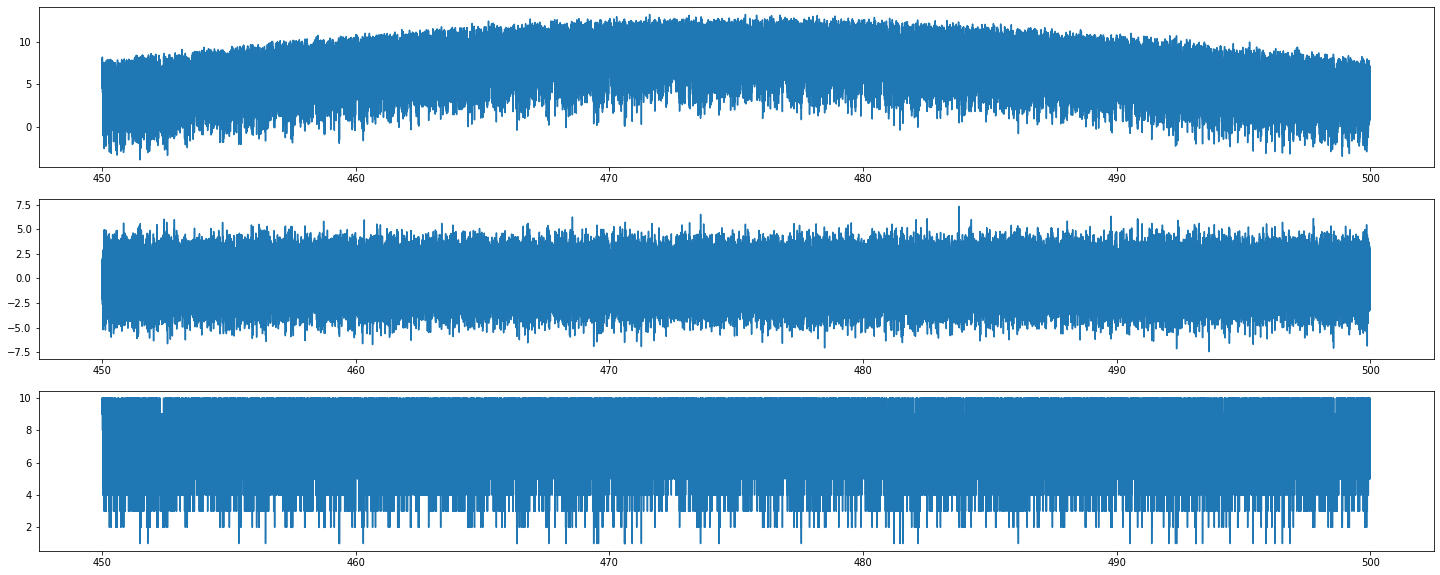

In [5]:
seg = 9

plt.figure(figsize=(25, 10))
plt.subplot(3, 1, 1)
plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.signal[seg*500000:(seg+1)*500000])
plt.subplot(3, 1, 2)
plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.detrended[seg*500000:(seg+1)*500000])
plt.subplot(3, 1, 3)
plt.plot(df_train.time[seg*500000:(seg+1)*500000], df_train.open_channels[seg*500000:(seg+1)*500000])

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64


<BarContainer object of 11 artists>

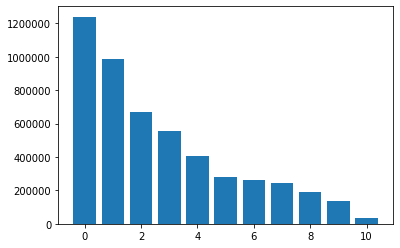

In [6]:
nuniq = df_train.open_channels.value_counts()
print(nuniq)
plt.bar(range(len(nuniq)), list(nuniq))

In [7]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

def get_model(input_shape, optimizer):
    
    def res_block(X, n_filters):
        X_skip = X
        
        X = Conv1D(filters=n_filters[0], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[1], kernel_size=3, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Conv1D(filters=n_filters[2], kernel_size=1, strides=1, padding='same')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X = Add()([X, X_skip])
        X = Activation('relu')(X)
        
        return X
        
    X_input = Input(shape=input_shape)
    X = Conv1D(filters=256, kernel_size=3, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2)(X)
    
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = res_block(X, [128, 128, 256])
    X = MaxPool1D(pool_size=2)(X)
    
    X = GRU(256)(X)
    
    #X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    X = Dense(11, activation='softmax')(X)
    
    # create the model
    #model = Sequential()
    #model.add(LSTM(128, input_shape=(X.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    #model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    #model.add(MaxPool1D(pool_size=2))
    #model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPool1D(pool_size=2))
    #model.add(GRU(128))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(11, activation='softmax'))

    model = Model(inputs=X_input, outputs=X, name='ResLSTM')
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #TODO add macro_f1
    model.summary()
    return model

In [ ]:
#TODO improve model by adding CONV1D and with it new learned features
#TODO shuffle training set somehow
#TODO split training set to training and validation

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

# macro f1 score with one-hot encoded labels
def macro_f1(yoh_true, yoh_pred):
    y_true = np.argmax(yoh_true, axis=-1)
    y_pred = np.argmax(yoh_pred, axis=-1)
    return f1_score(y_true, y_pred, average='macro')

# numpy data for training
seg = 9
X = df_train_X.to_numpy()[seg*500000:(seg+1)*500000]
y = df_train.open_channels.to_numpy()[seg*500000:(seg+1)*500000]
y_oh = to_categorical(y, num_classes=11)
groups = df_train.batch.to_numpy()[seg*500000:(seg+1)*500000]
#print(X.shape, y.shape)
#print(y)

# cross validation training
scores = []
#kf = GroupKFold(n_splits=10)
#kf = KFold(n_splits=2)
#kf = StratifiedKFold(n_splits=5)
kf = StratifiedShuffleSplit(n_splits=5, random_state=0)
for kth, (train_index, val_index) in enumerate(kf.split(X, y, groups)):
    print(f'Training {kth}. Fold')
    #print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    yoh_train, yoh_test = y_oh[train_index], y_oh[val_index]
    
    # scale data to 0-1 range and reshape
    x_scaler = MinMaxScaler()
    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)
    
    X_train = X_train.reshape((-1, SEQ_LEN, 1))
    print(X_train.shape)
    X_test = X_test.reshape((-1, SEQ_LEN, 1))
    
    # define model callbacks
    callback_checkpoint = ModelCheckpoint(filepath=f'best_model_{kth}fold.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               save_weights_only=True, 
                               save_best_only=True)
    callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                           factor=0.1, 
                                           patience=1, 
                                           verbose=1, 
                                           min_delta=1e-4, 
                                           min_lr=1e-5)
    callback_tensorboard = TensorBoard(log_dir=f'./logs_{kth}fold/', histogram_freq=0, write_graph=False)
    #cbs = [callback_checkpoint, callback_early_stopping, callback_reduce_lr, callback_tensorboard]
    cbs = [callback_early_stopping, callback_reduce_lr]
    
    opt_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model = get_model((X.shape[1], 1), opt_adam)
    
    # train model
    history = model.fit(X_train, yoh_train, epochs=200, batch_size=256, shuffle=True, verbose=1, validation_data=(X_test, yoh_test), callbacks=cbs)
    
    # calculate macro f1 on val set
    yoh_pred = model.predict(X_test)
    score = macro_f1(yoh_test, yoh_pred)
    print(f'val_macro_f1: {score}')
    scores.append(score)
    
    # plot loss and val_loss wrt epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    
print(scores)
print(np.mean(scores))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 201, 1)       0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 201, 256)     1024        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_30 (Batc (None, 201, 256)     1024        conv1d_30[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 201, 256)     0           batch_normalization_v1_30[0][0]  
__________________________________________________________________________________________________
max_poolin

(450000, 201, 1)
Train on 450000 samples, validate on 50000 samples
Epoch 1/200
450000/450000 [==============================] - 202s 449us/sample - loss: 1.4294 - acc: 0.3880 - val_loss: 1.5556 - val_acc: 0.3348
Epoch 2/200
449792/450000 [============================>.] - ETA: 0s - loss: 1.1447 - acc: 0.5066
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
450000/450000 [==============================] - 201s 447us/sample - loss: 1.1446 - acc: 0.5067 - val_loss: 2.4130 - val_acc: 0.2372
Epoch 3/200
450000/450000 [==============================] - 204s 454us/sample - loss: 0.7377 - acc: 0.6809 - val_loss: 0.7358 - val_acc: 0.6834
Epoch 4/200
450000/450000 [==============================] - 197s 437us/sample - loss: 0.6925 - acc: 0.7025 - val_loss: 0.6629 - val_acc: 0.7178
Epoch 5/200
449792/450000 [============================>.] - ETA: 0s - loss: 0.6113 - acc: 0.7425
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
450000

In [ ]:
sub.to_csv('submission.csv',index=False,float_format='%.4f')